Chat with a nutrition textbook

1. Open a PDF document (you could use almost any PDF here or even a collection of PDFs).
2. Format the text of the PDF textbook ready for an embedding model.
3. Embed all of the chunks of text in the textbook and turn them into numerical reprentations (embedding) which can store for later.
4. Build a retrieval system that uses vector search to find relevant chunk of text based on a query.
5. Create a prompt that incorporates the retrieved pieces of text.
6. Generate an answer to a query based on the passages of the textbook with an LLM.

All locally!

1. Steps 1-3: Document preprocessing and embedding creation.
2. Steps 4-6: Search and answer.

Steps

1. Import PDF doc
2. Process text for embedding
3. Embed text chunks with embedding model
4. Save embeddings

## Import PDF Document

In [91]:
!pip3 install PyMuPDF
!pip3 install tqdm

In [92]:
import fitz

from tqdm.auto import tqdm # progress bar

pdf_path = "human-nutrition-text.pdf"

def text_formatter(text: str) -> str:
    """Performs minor formatting on text"""
    cleaned_text = text.replace("\n", " ").strip()

    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number": page_number - 41,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4, # 1 token = ~ 4 characters
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path = pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [93]:
import random
random.sample(pages_and_texts, k=3)

[{'page_number': -12,
  'page_char_count': 376,
  'page_word_count': 62,
  'page_sentence_count_raw': 4,
  'page_token_count': 94.0,
  'text': 'Allison Calabrese  Allison Calabrese is currently a MS graduate student in the  Nutritional Sciences Program at University of Hawai‘i at Mānoa. She  obtained her BS from California Lutheran University in Exercise  Science with an emphasis in Health Professions. \xa0Her research  interests include the relationship between diet and optimal health.  xxx  |  About the Contributors'},
 {'page_number': 182,
  'page_char_count': 847,
  'page_word_count': 229,
  'page_sentence_count_raw': 22,
  'page_token_count': 211.75,
  'text': 'Food Group  Serving Size Sodium (mg)  Breads, all types  1 oz.  95–210  Rice Chex cereal  1 ¼ c.  292  Raisin Bran cereal  1 c.  362  Frozen pizza, plain, cheese  4 oz.  450–1200  Frozen vegetables, all types  ½ c.  2–160  Salad dressing, regular fat, all types 2 Tbsp.  110–505  Salsa  2 Tbsp.  150–240  Soup (tomato), recon

In [94]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [95]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15
std,348.86,560.44,95.75,6.19,140.11
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.75,134.00,4.00,190.69
50%,562.50,1232.50,215.00,10.00,308.12
75%,864.25,1605.25,271.25,14.00,401.31
max,1166.00,2308.00,429.00,32.00,577.00


1. Embedding models don't deal with infinte tokens
2. LLMs don't deal with infinite tokens (in thier context window)
3. Pack in good tokens (get the best bang for our buck)

## Further text processing (splitting pages into sentences)

2 ways to do this:

1. splitting based on ". "
2. split using an NLP library: spaCy & NLTK

In [96]:
!pip3 install -U pip setuptools wheel
!pip3 install -U 'spacy'

In [97]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [98]:
from spacy.lang.en import English

nlp = English()

# Add a Sentencizer pipeline
nlp.add_pipe("sentencizer")

doc = nlp("This is a sentence. This another sentence.")

list(doc.sents)

[This is a sentence., This another sentence.]

In [99]:
pages_and_texts[600]

{'page_number': 559,
 'page_char_count': 864,
 'page_word_count': 137,
 'page_sentence_count_raw': 8,
 'page_token_count': 216.0,
 'text': 'Image by  Allison  Calabrese /  CC BY 4.0  Korsakoff syndrome can cause similar symptoms as beriberi such  as confusion, loss of coordination, vision changes, hallucinations,  and may progress to coma and death. This condition is specific  to alcoholics as diets high in alcohol can cause thiamin deficiency.  Other individuals at risk include individuals who also consume diets  typically low in micronutrients such as those with eating disorders,  elderly, and individuals who have gone through gastric bypass  surgery.5  Figure 9.10 The Role of Thiamin  Figure 9.11 Beriberi, Thiamin Deficiency  5.\xa0Fact Sheets for Health Professionals: Thiamin. National  Institute of Health, Office of Dietary Supplements.  \xa0https:/ /ods.od.nih.gov/factsheets/Thiamin- HealthProfessional/. Updated Feburary 11, 2016.  Accessed October 22, 2017.  Water-Soluble Vitami

In [100]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [101]:
random.sample(pages_and_texts, k=1)

[{'page_number': 668,
  'page_char_count': 917,
  'page_word_count': 170,
  'page_sentence_count_raw': 7,
  'page_token_count': 229.25,
  'text': 'DRI values (μg/day)  Life stage group  RDA  Infants (0-12 months)  –  Children (1-3 years)  340  Children (4-8 years)  440  Children (9-13 years)  700  Adolescents (14-18 years)  890  Adults (>18 years)  900  1 Not Determinable\xa0 Source:  The National Academies Press (2006). Dietary Reference Intakes:  The Essential Guide to Nutrient Requirements. The National  Academies of Sciences Engineering Medicine.\xa0 Dietary Sources of Copper  Copper is distributed in many foods and is abundant in organ meats,  seafoods, nuts, and seeds. Wheat bran cereals, whole grains and  cocoa products are also good sources of copper. The absorption  of copper from foods may be reduced by excess intakes of zinc  and the amino acid histidine in addition to high intakes of iron and  fructose. Copper is also available as part of other ingredients in a  multiminera

In [102]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32
std,348.86,560.44,95.75,6.19,140.11,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


## Chunking our sentences together

1. Keeping it simple here: splitting in groups of 10 sentences
2. LangChain can be used, here Python will be used though

Why?
1. Texts are easier to filter
2. Text chunks can fit into embedding model
3. Contexts passed to an LLM can be more specific

In [103]:
num_sentence_chunk_size = 10

def split_list(input_list: list[str],
              slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [104]:
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [105]:
random.sample(pages_and_texts, k=1)

[{'page_number': 163,
  'page_char_count': 664,
  'page_word_count': 138,
  'page_sentence_count_raw': 2,
  'page_token_count': 166.0,
  'text': 'CO2 + H20 +  ATP); sources  of water loss:  Skin and  lungs  (insensible  water loss  0.9 L/day),  Urine 1.5 L/ day, Feces 0.1  L/day.  TOTAL  intake 2.2 L/ day +  Metabolic  Production  0.3 L/day –  Output  (0.9+1.5=0.1)  L/day = 0 ”  class=”wp-i mage-141  size-full”  width=”629″  height=”777″ > Daily Fluid  Loss and  Gain  \xa0 Dietary Recommendations  The Food and Nutrition Board of the Institute of Medicine (IOM) has  set the Adequate Intake (AI) for water for adult males at 3.7 liters  (15.6 cups) and at 2.7 liters (11 cups) for adult females.1 These intakes  1.\xa0Institute of Medicine Panel on Dietary Reference Intakes  Regulation of Water Balance  |  163',
  'sentences': ['CO2 + H20 +  ATP); sources  of water loss:  Skin and  lungs  (insensible  water loss  0.9 L/day),  Urine 1.5 L/ day, Feces 0.1  L/day.',
   ' TOTAL  intake 2.2 L/ d

In [106]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32,1.53
std,348.86,560.44,95.75,6.19,140.11,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00,1.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00,1.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


## Splitting each chunk into its own item

In [107]:
import re
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a para
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)

        chunk_dict["sentence_chunk"] = joined_sentence_chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [108]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 576,
  'sentence_chunk': 'Image by Allison Calabrese / CC BY 4.0 Vitamin B6 coenzyme is essential for the conversion of amino acid methionine into cysteine. With low levels of Vitamin B6, homocysteine will build up in the blood. High levels of homocysteine increases the risk for heart disease. Vitamin B6 Toxicity Currently, there are no adverse effects that have been associated with a high dietary intake of vitamin B6, but large supplemental doses can cause severe nerve impairment. To prevent this from occurring, the UL for adults is set at 100 mg/day. Dietary Reference Intakes The RDAs and ULs for different age groups for vitamin B6 are listed in Table 9.23 “Dietary Reference Intakes for Vitamin B6“. 576 | Water-Soluble Vitamins',
  'chunk_char_count': 713,
  'chunk_word_count': 118,
  'chunk_token_count': 178.25}]

In [109]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.83,112.72,183.71
std,347.79,447.43,71.07,111.86
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


In [110]:
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-41,Human Nutrition: 2020 Edition,29,4,7.25
1,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00
2,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50
3,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50
4,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25


## Filter out rows with length of tokens < 30

In [111]:
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1] ["chunk_token_count"]} | Text: {row[1] ["sentence_chunk"]}')

Chunk token count: 22.0 | Text: PART I CHAPTER 1. BASIC CONCEPTS IN NUTRITION Chapter 1. Basic Concepts in Nutrition | 1
Chunk token count: 5.5 | Text: 962 | Sports Nutrition
Chunk token count: 28.0 | Text: Fluid balance refers to maintaining the distribution of water in the body. 386 | Protein’s Functions in the Body
Chunk token count: 4.5 | Text: 516 | Introduction
Chunk token count: 5.5 | Text: 1050 | Comparing Diets


In [112]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [113]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 128,
  'sentence_chunk': 'downloadable versions (EPUB, Digital PDF, Print_PDF, or Open Document). Learning activities may be used across various mobile devices, however, for the best user experience it is strongly recommended that users complete these activities using a desktop or laptop computer and in Google Chrome. \xa0 An interactive or media element has been excluded from this version of the text. You can view it online here: http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=116 \xa0 128 | The Skeletal System',
  'chunk_char_count': 491,
  'chunk_word_count': 73,
  'chunk_token_count': 122.75}]

## Embedding the text chunks

In [114]:
!pip3 install -U sentence-transformers

In [115]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.ca

In [116]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cuda")

In [117]:
%%time
embedding_model.to("cuda")

for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 35.2 s, sys: 213 ms, total: 35.4 s
Wall time: 45.8 s


In [118]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

len(text_chunks)

%%time
embedding_model.to("cpu")

# Batches
text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size=16, convert_to_tensor=True) # batch_size influences how fast this line will run

UsageError: Line magic function `%%time` not found.


## Save embeddings to file

In [119]:
pages_and_chunks_over_min_token_len[419]

{'page_number': 277,
 'sentence_chunk': 'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture 

In [120]:
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"

In [121]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

## Import saved file and view

In [122]:
import pandas as pd
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


## Vector DB; if embeddings > 10M

## RAG - Search and Answer

- retrieve relevant passages based on a query
- use those passages to augment an input to an LLM and generate output based on those relevant passages

## Similarity Search

- Comparing embeddings is known as similarity search

In [123]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Creating torch embeddings
embeddings = torch.tensor(np.stack(text_chunks_and_embedding_df["embedding"].tolist(), axis=0), dtype=torch.float32).to(device)

pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

In [124]:
# Create model

from sentence_transformers import util, SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)

## Embedding Model ready

- Create a small semantic search pipeline
- define a query
- turn query string into an embedding
- perform a cosine similarity between text and query embeddings
- sort result in descending order

* ensure vector sizes are of same shape & tensors/vectors are of the same data type
* Popular indexing library - Faiss (Facebook AI similarity search) which provides ANN

In [125]:
query = "good foods for protein"
print(f"Query: {query}")

query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]

top_results_dot_product = torch.topk(dot_scores, k=5)

Query: good foods for protein


In [126]:
pages_and_chunks[42]

{'page_number': 5,
 'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of car

In [127]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [128]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'good foods for protein'

Results:
Score: 0.7729
Text:
Dietary Sources of Protein The protein food group consists of foods made from
meat, seafood, poultry, eggs, soy, dry beans, peas, and seeds. According to the
Harvard School of Public Health, “animal protein and vegetable protein probably
have the same effects on health. It’s the protein package that’s likely to make
a difference.”1 1. Protein: The Bottom Line. Harvard School of Public Proteins,
Diet, and Personal Choices | 411
Page number: 411


Score: 0.7647
Text:
Additionally, a person should consume 8 ounces of cooked seafood every week
(typically as two 4-ounce servings) to assure they are getting the healthy
omega-3 fatty acids that have been linked to a lower risk for heart disease.
Another tip is choosing to eat dry beans, peas, or soy products as a main dish.
Some of the menu choices include chili with kidney and pinto beans, hummus on
pita bread, and black bean enchiladas. You could also enjoy nuts in a variety of
w

In [129]:
!pip3 install matplotlib

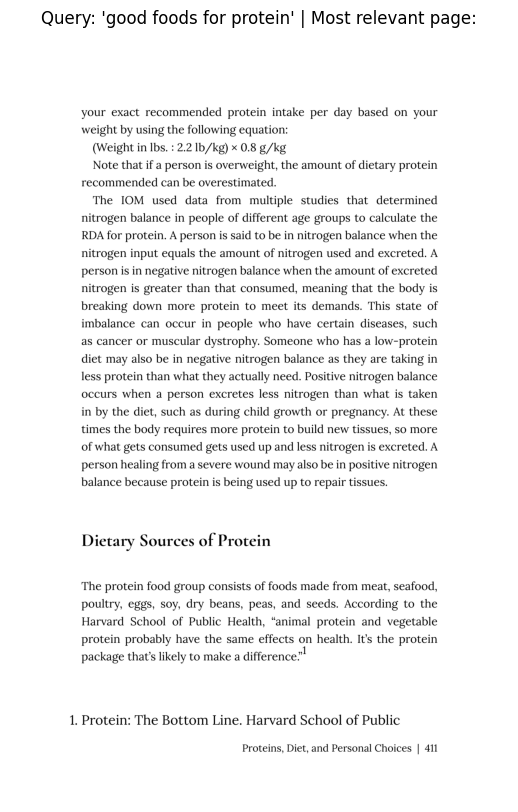

In [130]:
import fitz

# Open PDF and load target page
pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(411 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

## Functionizing the semantic search pipeline

Let's put all of the steps from above for semantic search into a function or two so we can repeat the workflow.

In [131]:
import torch
def retrieve_relevant_resources(query: str,
                               embeddings: torch.tensor,
                               model: SentenceTransformer=embedding_model,
                               n_resources_to_return: int=5,
                               print_time: bool=True):

    query_embedding = model.encode(query, convert_to_tensor=True)

    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0] # not cosine similarity because embeddings are normalized
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [132]:
query="foods high in fiber"
retrieve_relevant_resources(query=query, embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00008 seconds.
[INFO] Time taken to get scores on 1680 embeddings: 0.00008 seconds.
Query: foods high in fiber

Results:
Score: 0.6964
• Change it up a bit and experience the taste and satisfaction of other whole
grains such as barley, quinoa, and bulgur. • Eat snacks high in fiber, such as
almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green
peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
Page number: 276


Score: 0.6810
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a
few dietary sources of them are whole-grain foods, flax, cauliflower, and
avocados. Cellulose is the most abundant fiber in plants, making up the cell
walls and providing structure. Soluble fibers are more easily accessible t

## Getting an LLM for Local Generation

- Process will work with an LLM API as well

In [133]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.ca

In [134]:
import torch

gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


In [135]:
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


In [136]:
!pip3 install transformers

To load our LLM, we're going to need a few things:

1. A quantization config (optional) - This will determine whether or not we load the model in 4bit precision for lower memory usage.
2. A model ID - This is the reference Hugging Face model ID which will determine which tokenizer and model gets used. For example `gemma-7b-it`.
3. A tokenzier - This is what will turn our raw text into tokens ready for the model.
4. An LLM model - Again, using our model ID we can load a specific LLM model.

- As a bonus, we'll check if [Flash Attention 2] is available using `transformers.utils.is_flash_attn_2_available()`.
- Flash Attention 2 speeds up the attention mechanism in Transformer architecture models (which is what many modern LLMs are based on, including Gemma). So if it's available and the model is supported (not all models support Flash Attention 2), we'll use it. If it's not available, you can install it by following the instructions on the [GitHub repo](https://github.com/Dao-AILab/flash-attention).

In [137]:
!pip3 install bitsandbytes

In [138]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create a quantization config - !pip3 install bitsandbytes
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [139]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaR

In [140]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [141]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012344832, 'model_mem_mb': 4780.14, 'model_mem_gb': 4.67}

### Generating text with LLM

In [142]:
input_text = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles do they play in the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



In [143]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
         184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
            573,   3515,   2971, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
           573,   3515,   2971, 235336,    107,    108,    106,   2516,    108,
         21404, 235269,   1517, 235303, 235256,    476,  25497,    576,    573,
        186809, 184592,    578,   1024,  16065,    575,    573,   3515,   2971,
        235292,    109,    688,  12298,   1695, 184592,  66058,    109, 235287,
          5231, 156615,  56227,  66058,    108,   

In [144]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:**
    * Provide energy for the body's cells and tissues.
    * Carbohydrates are the primary source of energy for most cells.
    * Complex carbohydrates are those that take longer to digest, such as whole grains, fruits, and vegetables.
    * Simple carbohydrates are those that are quickly digested, such as sugar, starch, and lactose.

* **Proteins:**
    * Build and repair tissues, enzymes, and hormones.
    * Proteins are essential for immune function, hormone production, and tissue repair.
    * There are different types of proteins, each with specific functions.

* **Fats:**
    * Provide energy, insulation, and help absorb vitamins.
    * Healthy fats include olive oil, avocado, nuts, and seeds.
  

In [145]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What are the macronutrients, and what roles do they play in the human body?

Output text:
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:**
    * Provide energy for the body's cells and tissues.
    * Carbohydrates are the primary source of energy for most cells.
    * Complex carbohydrates are those that take longer to digest, such as whole grains, fruits, and vegetables.
    * Simple carbohydrates are those that are quickly digested, such as sugar, starch, and lactose.

* **Proteins:**
    * Build and repair tissues, enzymes, and hormones.
    * Proteins are essential for immune function, hormone production, and tissue repair.
    * There are different types of proteins, each with specific functions.

* **Fats:**
    * Provide energy, insulation, and help absorb vitamins.
    * Healthy fats include olive oil, avocado, nuts, and seeds.
    * Trans fats can raise cholesterol levels and increase the r

In [146]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [147]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: water soluble vitamins
[INFO] Time taken to get scores on 1680 embeddings: 0.00008 seconds.


(tensor([0.7893, 0.7625, 0.7386, 0.7099, 0.6996], device='cuda:0'),
 tensor([855, 801, 756, 755, 848], device='cuda:0'))

### Augmenting the prompt with context items

In essence, we start with a base prompt and update it with context text.

Let's write a function called `prompt_formatter` that takes in a query and our list of context items (in our case it'll be select indices from our list of dictionaries inside `pages_and_chunks`) and then formats the query with text from the context items.

We'll apply the dialogue and chat template to our prompt before returning it as well.

In [148]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [149]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: What are symptoms of pellagra?
[INFO] Time taken to get scores on 1680 embeddings: 0.00007 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone me

In [150]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: What are symptoms of pellagra?
RAG answer:
<bos>Sure, here are the symptoms of pellagra:

- Diarrhea
- Dermatitis
- Dementia
- Even death<eos>
CPU times: user 1.32 s, sys: 26.4 ms, total: 1.34 s
Wall time: 1.96 s


### Functionizing the pipeline

In [151]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [159]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
ask(query=query, temperature=0.7, return_answer_only = False)


Query: What is the RDI for protein per day?
[INFO] Time taken to get scores on 1680 embeddings: 0.00008 seconds.


('The relevant passage in the context is Table 6.2 Dietary Reference Intakes for Protein, Food, and Personal Choices, which states:\n\n> "The Recommended Daily Allowance (RDA) for protein for different age groups is listed in Table 6.2 "Dietary Reference Intakes for Protein". A Tolerable Upper Intake Limit for protein has not been set, but it is recommended that you do not exceed the upper end of the AMDR."',
 [{'page_number': 410,
   'sentence_chunk': 'Most nitrogen is lost as urea in the urine, but urea is also excreted in the feces. Proteins are also lost in sweat and as hair and nails grow. The RDA, therefore, is the amount of protein a person should consume in their diet to balance the amount of protein used up and lost from the body. For healthy adults, this amount of protein was determined to be 0.8 grams of protein per kilogram of body weight. You can calculate 410 | Proteins, Diet, and Personal Choices',
   'chunk_char_count': 466,
   'chunk_word_count': 87,
   'chunk_token_co